--- Starting Process with 462 rows ---
1. Cleaning data types and formatting...
2. Fixing outliers and imputing missing values...
   - Fixed 56 rows with scalar errors (e.g. 30588 -> 30.588)
3. Creating 'Golden Features'...
4. Data ready. Training samples: 429
5. Training Random Forest...

>>> RESULTS: Model MAE: 0.9562 percentage points


/var/folders/qv/w6gmqgrs64b5x2c7vhrcz92w0000gr/T/ipykernel_33258/2689486011.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['classroom_density'].fillna(df_clean['classroom_density'].median(), inplace=True)
/var/folders/qv/w6gmqgrs64b5x2c7vhrcz92w0000gr/T/ipykernel_33258/2689486011.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', da

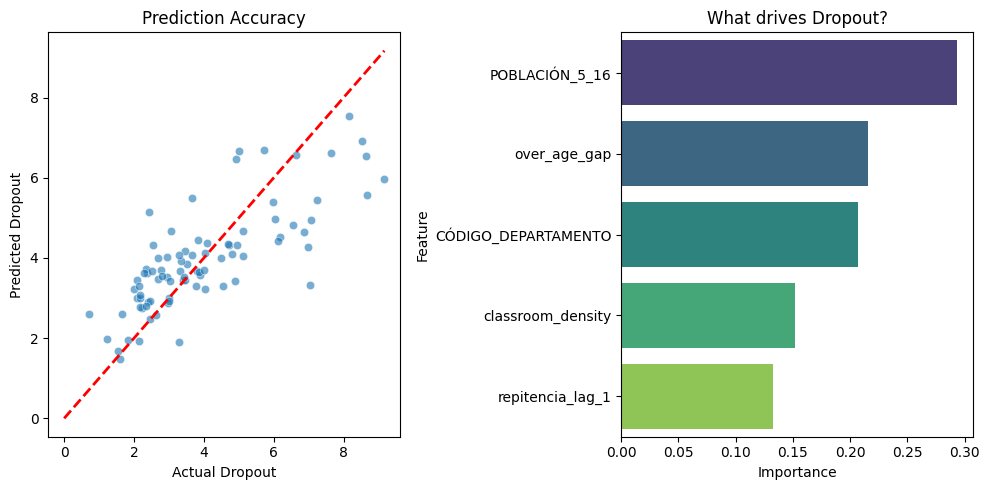

In [2]:
# ==============================================================================
# MASTER CELL: CLEANING, ENGINEERING, AND TRAINING
# Copy this entire block into a Jupyter Notebook cell.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- 1. LOAD DATA (Use your existing 'df' or load it here) ---
# If you haven't loaded the data yet, uncomment the line below:
df = pd.read_csv('Colombia_education_departamento.csv') 

# Check if 'df' exists to prevent errors
if 'df' not in locals():
    raise ValueError("Please make sure your dataframe is loaded into a variable named 'df' before running this cell!")

print(f"--- Starting Process with {len(df)} rows ---")

# Keep a copy of the original just in case
df_clean = df.copy()

# ==============================================================================
# STEP 2: DATA CLEANING & TYPE CONVERSION
# ==============================================================================
print("1. Cleaning data types and formatting...")

# Columns that might be text with '%' or ','
cols_to_fix = ['COBERTURA_NETA', 'COBERTURA_BRUTA', 'DESERCIÓN', 
               'REPITENCIA', 'TAMAÑO_PROMEDIO_DE_GRUPO']

for col in cols_to_fix:
    if col in df_clean.columns:
        # Only process if it is currently stored as an object (string)
        if df_clean[col].dtype == 'object':
            # Remove % and replace comma with dot (European -> US format)
            df_clean[col] = df_clean[col].astype(str).str.replace('%', '').str.replace(',', '.', regex=False)
        # Convert to numeric (errors='coerce' turns weird text into NaN)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows where we don't have the target variable (Dropout Rate)
df_clean.dropna(subset=['DESERCIÓN'], inplace=True)

# ==============================================================================
# STEP 3: SMART IMPUTATION & THE "COMMA" FIX
# ==============================================================================
print("2. Fixing outliers and imputing missing values...")

# Standardize column name
if 'TAMAÑO_PROMEDIO_DE_GRUPO' in df_clean.columns:
    df_clean.rename(columns={'TAMAÑO_PROMEDIO_DE_GRUPO': 'classroom_density'}, inplace=True)

# A. Fix the "Comma vs Dot" Monster (e.g., 30588 students -> 30.5 students)
# Logic: Any class size > 100 is impossible. Divide by 1000.
outlier_mask = df_clean['classroom_density'] > 100
num_outliers = outlier_mask.sum()
if num_outliers > 0:
    print(f"   - Fixed {num_outliers} rows with scalar errors (e.g. 30588 -> 30.588)")
    df_clean.loc[outlier_mask, 'classroom_density'] = df_clean.loc[outlier_mask, 'classroom_density'] / 1000

# B. Impute missing class density using Department Median
df_clean['classroom_density'] = df_clean.groupby('CÓDIGO_DEPARTAMENTO')['classroom_density'].transform(
    lambda x: x.fillna(x.median())
)
# Fallback for completely empty departments
df_clean['classroom_density'].fillna(df_clean['classroom_density'].median(), inplace=True)

# ==============================================================================
# STEP 4: FEATURE ENGINEERING (CREATING THE GOLDEN FEATURES)
# ==============================================================================
print("3. Creating 'Golden Features'...")

# Feature A: Over-Age Gap (Social Risk)
df_clean['over_age_gap'] = df_clean['COBERTURA_BRUTA'] - df_clean['COBERTURA_NETA']

# Feature B: Repetition Lag (Predicting future dropout based on past failure)
# We sort first to ensure the shift works correctly
df_clean = df_clean.sort_values(by=['CÓDIGO_DEPARTAMENTO', 'AÑO'])
df_clean['repitencia_lag_1'] = df_clean.groupby('CÓDIGO_DEPARTAMENTO')['REPITENCIA'].shift(1)

# ==============================================================================
# STEP 5: PREPARE FOR TRAINING (REMOVE LEAKAGE)
# ==============================================================================
# Drop Leakage columns (Approval/Failure) and the "dirty" Internet column
cols_to_drop = ['APROBACIÓN', 'REPROBACIÓN', 'SEDES_CONECTADAS_A_INTERNET']
# Also drop rows with NaNs created by the Lag (the first year of data)
df_final = df_clean.drop(columns=cols_to_drop, errors='ignore').dropna(subset=['repitencia_lag_1', 'over_age_gap'])

print(f"4. Data ready. Training samples: {len(df_final)}")

# ==============================================================================
# STEP 6: TRAIN RANDOM FOREST
# ==============================================================================
print("5. Training Random Forest...")

# Select specific features
predictors = ['over_age_gap', 'repitencia_lag_1', 'classroom_density', 'POBLACIÓN_5_16', 'CÓDIGO_DEPARTAMENTO']
# Ensure predictors exist
predictors = [c for c in predictors if c in df_final.columns]

X = df_final[predictors]
y = df_final['DESERCIÓN']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n>>> RESULTS: Model MAE: {mae:.4f} percentage points")

# ==============================================================================
# STEP 7: VISUALIZATION
# ==============================================================================
plt.figure(figsize=(10, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Dropout')
plt.ylabel('Predicted Dropout')
plt.title('Prediction Accuracy')

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
importances = rf_model.feature_importances_
feat_df = pd.DataFrame({'Feature': predictors, 'Importance': importances}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('What drives Dropout?')

plt.tight_layout()
plt.show()

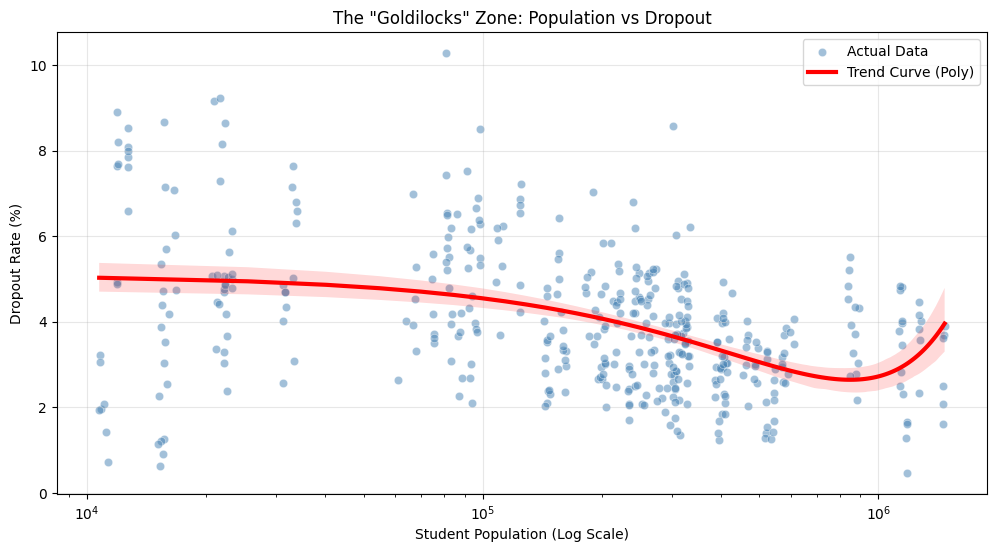

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))

# 1. Scatter Plot
sns.scatterplot(data=df_final, x='POBLACIÓN_5_16', y='DESERCIÓN', 
                alpha=0.5, color='steelblue', label='Actual Data')

# 2. Simpler Trend Line (Polynomial Order 2)
# This creates a curved line (parabola) without needing 'statsmodels'
sns.regplot(data=df_final, x='POBLACIÓN_5_16', y='DESERCIÓN', 
            scatter=False, order=2,  # <--- order=2 makes it curvy (U-shape)
            line_kws={'color': 'red', 'linewidth': 3}, label='Trend Curve (Poly)')

plt.xscale('log') # This will un-squash your data
plt.xlabel('Student Population (Log Scale)')
plt.ylabel('Dropout Rate (%)')
plt.title('The "Goldilocks" Zone: Population vs Dropout')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()